<a href="https://colab.research.google.com/github/antoniomuso/speech2face/blob/master/Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
! pip3 install face_recognition
! pip3 install tensorflow-gpu==1.15

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from PIL import Image
import face_recognition

PATH = "http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth"

In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
# Download Dataset
# Test Set
# ! wget -x --load-cookies "/content/drive/My Drive/Speech2Face/cookies.txt" -O "/content/drive/My Drive/Speech2Face/vggface2_test.tar.gz" http://zeus.robots.ox.ac.uk/vgg_face2/get_file?fname=vggface2_test.tar.gz

#! tar -zxvf "/content/drive/My Drive/Speech2Face/vggface2_test.tar.gz" -C "/content/drive/My Drive/Speech2Face/data_test"
# Training Set 
# ! wget -x --load-cookies "/content/drive/My Drive/Speech2Face/cookies.txt" -O "/content/drive/My Drive/Speech2Face/vggface2_test.tar.gz" http://zeus.robots.ox.ac.uk/vgg_face2/get_file?fname=vggface2_test.tar.gz

In [167]:
#VGG-16 Face Encoder Class
! pip install torchfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchfile



class VGG_16(nn.Module):
    """
    Main Class
    """

    def __init__(self):
        """
        Constructor
        """
        super().__init__()
        self.block_size = [2, 2, 3, 3, 3]
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 2622)

    def load_weights(self, path="/content/drive/My Drive/Speech2Face/alt/vgg_weights/vgg_face_torch/VGG_FACE.t7"):

        """ Function to load luatorch pretrained
        Args:
            path: path for the luatorch pretrained
        """
        model = torchfile.load(path)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
            if layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
                else:
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]

    def forward(self, x):
        """ Pytorch forward
        Args:
            x: input image (224x224)
        Returns: class logits
        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        #return self.fc7(x) #new added
        #return F.relu(self.fc7(x))

        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, self.training)

        x = F.normalize(x, p=2, dim=1)
        return x

        #return self.fc8(x) 


    def forward_two(self, x):
        """ Pytorch forward
        Args:
            x: input image (224x224)
        Returns: class logits
        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, self.training)
        return self.fc8(x)

In [205]:
from os.path import join
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
from time import time
import face_recognition
from random import randint
from google.colab.patches import cv2_imshow

class Decoder_Dataset(Dataset):
     

    def __init__(self, Folder, VggL, sample, dev = "cuda"):

        self.root     = Folder
        self.dev      = dev 
        self.names    = os.listdir(self.root) 
        self.sample   = sample if sample < 20 else 20
        self.a_length = len(os.listdir(self.root)) 
        self.length   = self.a_length * self.sample
        self.img_name = self.root + "{}.jpg"
        self.vgg_features = VggL
        self.vgg = VGG_16()
        self.vgg.load_weights()
        self.vgg.eval()
        print(self.a_length)

    def image_out(self,path, mean =[0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]):#[0.485, 0.456, 0.406]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        image = Image.open(path)
        count = 0
        resultant = []
        try:
            faceLocation = face_recognition.face_locations(img)[count]
            x,y1,x1,y = faceLocation
            img = img[x:x1,y:y1]
            landmark = face_recognition.face_landmarks(img)
            for i in list(landmark[0].keys()):
                resultant += landmark[0][i]
            landmark = np.ravel(np.array(resultant))
            img = cv2.resize(img, (224,224),  interpolation = cv2.INTER_AREA)

            loader = transforms.Compose([
                 transforms.Resize((224,224), interpolation = cv2.INTER_AREA),
                 transforms.ToTensor(),
                 transforms.Normalize(mean, std),
             ])
            
            img_t = loader(image)
            
            img_t = torch.reshape(img_t, (-1, 3, 224, 224))
            biden_encoding = self.vgg(img_t)
            # cv2_imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            
        except IndexError:
            return None, None, None
        
        
        return  biden_encoding.detach().numpy(), img.reshape(1,224,224,3), np.ravel(np.array(landmark))



    def pseudo_idx(self,idx):
        if idx < self.a_length:
            return idx
        else:
            ## return self.pseudo_idx(idx - self.a_length) ## RECURSION
            return idx // self.sample 

    def __len__(self):
        return self.length

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        while True:
            index = idx
            index = self.pseudo_idx(index)
            name  = index 
            path =  self.img_name.format(name)
            # print(path)

            if not os.path.exists(path):
                idx = randint(0, self.a_length) # IF FILE PATH DOESNOT EXISTS
                continue

            feature, image, landmark= self.image_out(path)
            if image is None:
                idx = randint(0, self.a_length) # IF FILE PATH DOESNOT EXISTS
                continue

            image = torch.from_numpy(image).view(3,224,224).float()
            return   torch.from_numpy(feature).float(), image,torch.from_numpy(landmark).float()

In [169]:
############### THIS CELL IS COPIED FROM DEEP SPEECH MOZILLA #########################


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow.compat.v1 as tfv1
from tensorflow.compat import dimension_value
from tensorflow.contrib.image import dense_image_warp
from tensorflow.contrib.image import interpolate_spline

from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops

def _to_float32(value):
    return tf.cast(value, tf.float32)

def _to_int32(value):
    return tf.cast(value, tf.int32)

def _get_grid_locations(image_height, image_width):
    """Wrapper for np.meshgrid."""
    tfv1.assert_type(image_height, tf.int32)
    tfv1.assert_type(image_width, tf.int32)

    y_range = tf.range(image_height)
    x_range = tf.range(image_width)
    y_grid, x_grid = tf.meshgrid(y_range, x_range, indexing='ij')
    return tf.stack((y_grid, x_grid), -1)


def _expand_to_minibatch(tensor, batch_size):
    """Tile arbitrarily-sized np_array to include new batch dimension."""
    ndim = tf.size(tf.shape(tensor))
    ones = tf.ones((ndim,), tf.int32)

    tiles = tf.concat(([batch_size], ones), 0)
    return tf.tile(tf.expand_dims(tensor, 0), tiles)


def _get_boundary_locations(image_height, image_width, num_points_per_edge):
    """Compute evenly-spaced indices along edge of image."""
    image_height_end = _to_float32(tf.math.subtract(image_height, 1))
    image_width_end = _to_float32(tf.math.subtract(image_width, 1))
    y_range = tf.linspace(0.0, image_height_end, num_points_per_edge + 2)
    x_range = tf.linspace(0.0, image_height_end, num_points_per_edge + 2)
    ys, xs = tf.meshgrid(y_range, x_range, indexing='ij')
    is_boundary = tf.logical_or(
        tf.logical_or(tf.equal(xs, 0.0), tf.equal(xs, image_width_end)),
        tf.logical_or(tf.equal(ys, 0.0), tf.equal(ys, image_height_end)))
    return tf.stack([tf.boolean_mask(ys, is_boundary), tf.boolean_mask(xs, is_boundary)], axis=-1)


def _add_zero_flow_controls_at_boundary(control_point_locations,
                                        control_point_flows, image_height,
                                        image_width, boundary_points_per_edge):
    """Add control points for zero-flow boundary conditions.
     Augment the set of control points with extra points on the
     boundary of the image that have zero flow.
    Args:
      control_point_locations: input control points
      control_point_flows: their flows
      image_height: image height
      image_width: image width
      boundary_points_per_edge: number of points to add in the middle of each
                             edge (not including the corners).
                             The total number of points added is
                             4 + 4*(boundary_points_per_edge).
    Returns:
      merged_control_point_locations: augmented set of control point locations
      merged_control_point_flows: augmented set of control point flows
    """

    batch_size = dimension_value(tf.shape(control_point_locations)[0])

    boundary_point_locations = _get_boundary_locations(image_height, image_width,
                                                       boundary_points_per_edge)
    boundary_point_shape = tf.shape(boundary_point_locations)
    boundary_point_flows = tf.zeros([boundary_point_shape[0], 2])

    minbatch_locations = _expand_to_minibatch(boundary_point_locations, batch_size)
    type_to_use = control_point_locations.dtype
    boundary_point_locations = tf.cast(minbatch_locations, type_to_use)

    minbatch_flows = _expand_to_minibatch(boundary_point_flows, batch_size)

    boundary_point_flows = tf.cast(minbatch_flows, type_to_use)

    merged_control_point_locations = tf.concat(
        [control_point_locations, boundary_point_locations], 1)

    merged_control_point_flows = tf.concat(
        [control_point_flows, boundary_point_flows], 1)

    return merged_control_point_locations, merged_control_point_flows


def sparse_image_warp(image,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundary_points=0,
                      name='sparse_image_warp'):
    """Image warping using correspondences between sparse control points.
    Apply a non-linear warp to the image, where the warp is specified by
    the source and destination locations of a (potentially small) number of
    control points. First, we use a polyharmonic spline
    (`tf.contrib.image.interpolate_spline`) to interpolate the displacements
    between the corresponding control points to a dense flow field.
    Then, we warp the image using this dense flow field
    (`tf.contrib.image.dense_image_warp`).
    Let t index our control points. For regularization_weight=0, we have:
    warped_image[b, dest_control_point_locations[b, t, 0],
                    dest_control_point_locations[b, t, 1], :] =
    image[b, source_control_point_locations[b, t, 0],
             source_control_point_locations[b, t, 1], :].
    For regularization_weight > 0, this condition is met approximately, since
    regularized interpolation trades off smoothness of the interpolant vs.
    reconstruction of the interpolant at the control points.
    See `tf.contrib.image.interpolate_spline` for further documentation of the
    interpolation_order and regularization_weight arguments.
    Args:
      image: `[batch, height, width, channels]` float `Tensor`
      source_control_point_locations: `[batch, num_control_points, 2]` float
        `Tensor`
      dest_control_point_locations: `[batch, num_control_points, 2]` float
        `Tensor`
      interpolation_order: polynomial order used by the spline interpolation
      regularization_weight: weight on smoothness regularizer in interpolation
      num_boundary_points: How many zero-flow boundary points to include at
        each image edge.Usage:
          num_boundary_points=0: don't add zero-flow points
          num_boundary_points=1: 4 corners of the image
          num_boundary_points=2: 4 corners and one in the middle of each edge
            (8 points total)
          num_boundary_points=n: 4 corners and n-1 along each edge
      name: A name for the operation (optional).
      Note that image and offsets can be of type tf.half, tf.float32, or
      tf.float64, and do not necessarily have to be the same type.
    Returns:
      warped_image: `[batch, height, width, channels]` float `Tensor` with same
        type as input image.
      flow_field: `[batch, height, width, 2]` float `Tensor` containing the dense
        flow field produced by the interpolation.
    """

    image = ops.convert_to_tensor(image)
    source_control_point_locations = ops.convert_to_tensor(
        source_control_point_locations)
    dest_control_point_locations = ops.convert_to_tensor(
        dest_control_point_locations)

    control_point_flows = (
        dest_control_point_locations - source_control_point_locations)

    clamp_boundaries = num_boundary_points > 0
    boundary_points_per_edge = num_boundary_points - 1

    with ops.name_scope(name):
        image_shape = tf.shape(image)
        batch_size, image_height, image_width = image_shape[0], image_shape[1], image_shape[2]

        # This generates the dense locations where the interpolant
        # will be evaluated.
        grid_locations = _get_grid_locations(image_height, image_width)

        flattened_grid_locations = tf.reshape(grid_locations,
                                              [tf.multiply(image_height, image_width), 2])

        # flattened_grid_locations = constant_op.constant(
        #     _expand_to_minibatch(flattened_grid_locations, batch_size), image.dtype)
        flattened_grid_locations = _expand_to_minibatch(flattened_grid_locations, batch_size)
        flattened_grid_locations = tf.cast(flattened_grid_locations, dtype=image.dtype)

        if clamp_boundaries:
            (dest_control_point_locations,
             control_point_flows) = _add_zero_flow_controls_at_boundary(
                 dest_control_point_locations, control_point_flows, image_height,
                 image_width, boundary_points_per_edge)

        flattened_flows = interpolate_spline(
            dest_control_point_locations, control_point_flows,
            flattened_grid_locations, interpolation_order, regularization_weight)

        dense_flows = array_ops.reshape(flattened_flows,
                                        [batch_size, image_height, image_width, 2])

        warped_image = dense_image_warp(image, dense_flows)

        return warped_image, dense_flows

In [170]:
def image_warping(src_img, src_landmarks, dest_landmarks):
    # expanded_src_landmarks = np.expand_dims(np.float32(src_landmarks), axis=0)
    # expanded_dest_landmarks = np.expand_dims(np.float32(dest_landmarks), axis=0)
    # expanded_src_img = np.expand_dims(np.float32(src_img) / 255, axis=0)

    warped_img, dense_flows = sparse_image_warp(src_img,
                          src_landmarks,
                          dest_landmarks,
                          interpolation_order=1,
                          regularization_weight=0.1,
                          num_boundary_points=2,
                          name='sparse_image_warp')

    with tf.Session() as sess:
        out_img = sess.run(warped_img)
        warp_img = np.uint8(out_img[:, :, :, :] * 255)
    
    return warp_img
    
def face_landmark(img):
    X = np.zeros((img.shape[0], 72 ,2))
    flag = []
    for i in range(img.shape[0]):

        landmark = face_recognition.face_landmarks(img[i].reshape(224,224,3))
        resultant = []
        try:
            for j in list(landmark[0].keys()):
                resultant += landmark[0][j] 
        except IndexError:
            flag.append(i)
            continue
        X[i] = np.array(resultant)
    return  X, flag

In [171]:
import torch 
from torch import nn

class DECODER(nn.Module):
    def __init__(self, phase):
        super(DECODER, self).__init__()
        self.phase = phase
        self.fc3 = nn.Linear(4096, 1000)
        self.ReLU = nn.ReLU()
        #self.fc_bn3 = nn.BatchNorm1d(1000)


        self.fc4 = nn.Linear(1000, 14 * 14 * 64)
        self.fc_bn4 = nn.BatchNorm1d(14 * 14 * 64)
        def TransConv( i, kernal = 5, stride = 2, inp = None):
            if not inp:
                inp = max(256//2**(i-1), 32)

            layer =  nn.Sequential(
                nn.ConvTranspose2d(inp, max(256//2**i, 32), 
                                kernal, stride=stride, padding=2, output_padding=1, 
                                dilation=1, padding_mode='zeros'),
                nn.ReLU(),
                nn.BatchNorm2d(max(256//2**i, 32)))
            return layer
        self.T1_ = TransConv(1, inp = 64)
        self.T2_ = TransConv(2)
        self.T3_ = TransConv(3)
        self.T4_ = TransConv(4)
    
        self.ConvLast = nn.Sequential(
            nn.Conv2d(32, 3, (1,1), stride=1),
            nn.BatchNorm2d(3),
            nn.ReLU())


        self.layerLandmark1 = nn.Linear(1000, 800)
        self.layerLandmark2 = nn.Linear(800, 600)
        self.layerLandmark3 = nn.Linear(600, 400)
        self.layerLandmark4 = nn.Linear(400, 200)
        self.layerLandmark5 = nn.Linear(200, 144)





        


    def forward(self, x):
        L1 = self.fc3(x)
        L1 = self.ReLU(L1)


        L2 = self.layerLandmark1(L1)
        L2 = self.ReLU(L2)

        L3 = self.layerLandmark2(L2)
        L3 = self.ReLU(L3)

        L4 = self.layerLandmark3(L3)
        L4 = self.ReLU(L4)

        L5 = self.layerLandmark4(L4)
        L5 = self.ReLU(L5)

        L6 = self.layerLandmark5(L5)
        outL = self.ReLU(L6)


        # B1 = self.fc_bn3(L1) 
        T0 = self.fc4(L1) 
        T0 = self.ReLU(T0)
        # T0 = self.fc_bn4(T0)
        T0 = T0.view(-1,64,14,14)



        T1 = self.T1_(T0)
        T2 = self.T2_(T1)
        T3 = self.T3_(T2)
        T4 = self.T4_(T3)

        outT = self.ConvLast(T4)
        if self.phase == "train":
            return outL,  outT 
        elif self.phase == "eval":
            img = outT.cpu().detach().numpy().reshape(-1, 224, 224, 3)*255
            outL = outL.cpu().detach().numpy()
            outL = np.dstack((outL[:,0::2],outL[:,1::2]))
            #print("land np img np ", outL_.shape, img_.shape)
            img = (img.reshape(-1,224,224,3)*255).astype(np.uint8)
            #print("img_t ",img_t.shape, img_t[0])
            src, flag = face_landmark(img)
            if flag:
                for r in flag:
                    src[r] = outL[r]

            return image_warping(img.astype(np.float32), src.astype(np.float32), outL.astype(np.float32))

            
        # outN = outT.numpy()
        # outLN = outL.numpy()
        # src, flag = face_landmark(outN)
        # if flag:
        #     for r in flag:
        #         src[r] = outLN[r]
        
        # IMG = torch.from_numpy(image_warping(outN, src, outLN))
        
        # if self.phase == "train":
        #     return outL,  outT , VGGL(IMG)
        # if self.phase == "test":
        #     return IMG

In [172]:

from torchsummary import summary
device = "cuda" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DECODER("train")
model = model.cuda()
summary(model, input_size=(4096,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]       4,097,000
              ReLU-2                 [-1, 1000]               0
            Linear-3                  [-1, 800]         800,800
              ReLU-4                  [-1, 800]               0
            Linear-5                  [-1, 600]         480,600
              ReLU-6                  [-1, 600]               0
            Linear-7                  [-1, 400]         240,400
              ReLU-8                  [-1, 400]               0
            Linear-9                  [-1, 200]          80,200
             ReLU-10                  [-1, 200]               0
           Linear-11                  [-1, 144]          28,944
             ReLU-12                  [-1, 144]               0
           Linear-13                [-1, 12544]      12,556,544
             ReLU-14                [-1

In [206]:
import os
optimizer = torch.optim.Adam(model.parameters(), lr=0.009)
criterion_1 = nn.MSELoss()
criterion_2 = nn.L1Loss()
criterion_3 = nn.CosineEmbeddingLoss()
alpha = 0.0002
beta  = 1.0
#gamma = 1.5
l = 10
BATCH = 20
WORKER = 0
SAMPLE = 20
num_epochs = 5
sim = torch.ones((BATCH,1, 128 ))
train_dataset = Decoder_Dataset("/content/drive/My Drive/Speech2Face/data_test/faces/", sample = SAMPLE, VggL = "vgg16")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
		                                           batch_size=BATCH, 
		                                           num_workers =WORKER,
		                                           shuffle=False)

3630


In [174]:
#! mkdir checkpoint

In [175]:
import nvidia_smi
import psutil
import platform

nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

Epoch 0
2020-08-13 11:10:00.377091 : Epoch [1/5], Step [0/3630], Loss: 9733.4492, gpu: 0%, gpu-mem: 0%, RAM: 23.5% , RAM Mem 31.7%, running_loss: 48.6672, MSEloss 22.5599, MAEloss 0.4822,  time: 10.5049,  


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([20, 144])) that is different to the input size (torch.Size([20, 1, 144])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


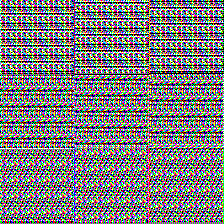

2020-08-13 11:11:48.617881 : Epoch [1/5], Step [10/3630], Loss: 11828.2773, gpu: 65%, gpu-mem: 29%, RAM: 49.5% , RAM Mem 31.7%, running_loss: 533.7236, MSEloss 493.0832, MAEloss 5.2386,  time: 108.2408,  


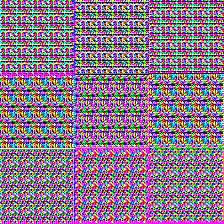

In [ ]:
from datetime import datetime

for epoch in range(num_epochs):
    print("Epoch", epoch)
    running_loss = 0.0
    running_loss_1 = 0.0
    running_loss_2 = 0.0
    start_time = time()
    for  i,(feature, img, landm) in enumerate(train_loader):
        
        # Move tensors to the configured device
        img = img.to(device)
        landm = landm.to(device)
        #print("input",img.size(), landm.size())
        feature = feature.to(device)
        #print("vgg",feature.size())
        # Forward pass
        outL, outT = model(feature)
        #print("output ", outL.size(), outT.size())

        loss_1 = criterion_1(outL, landm)
        loss_2 = criterion_2(outT, img)
        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()

        # img_ = outT.cpu().detach().numpy()
        # outL_ = outL.cpu().detach().numpy()
        # outL_ = np.dstack((outL_[:,0::2],outL_[:,1::2]))
        # #print("land np img np ", outL_.shape, img_.shape)
        # img_t = (img_.reshape(-1,224,224,3)*255).astype(np.uint8)
        # #print("img_t ",img_t.shape, img_t[0])
        # if epoch in [0, 1]:
        #     src, flag    = face_landmark(img_t)
        #     if flag:
        #         for f in flag:
        #             src[f] = outL_[f]
        # else:

        #     outL_ = landm.cpu().detach().numpy()

        # img_ = image_warping(img_.astype(np.float32), src.astype(np.float32), outL_.astype(np.float32)).to(device)

        # # print(img_.size(), type(img_))
        # # print(feature.size())
        # feature_out = vgg16(img_)
        # # print(feature_out.size(), sim.size())

        # loss_3 = criterion_3(feature_out.view(BATCH,1,4096).to(device), feature.view(BATCH,1,4096), sim.view(BATCH,1,4096).to(device))
        # running_loss_3 += loss_3.item()



        loss = (alpha*loss_1 + beta*loss_2 )*100
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % l == 0:
            # writer.add_scalar('training loss',running_loss/  data["show"],epoch * len(train_loader) + i)
            res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
            print('{} : Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, gpu: {}%, gpu-mem: {}%, RAM: {}% , RAM Mem {}%, running_loss: {:.4f}, MSEloss {:.4f}, MAEloss {:.4f},  time: {:.4f},  '.format(datetime.now() ,epoch+1, num_epochs, i,int((train_dataset.__len__()/BATCH)),  loss.item(),res.gpu, res.memory,psutil.cpu_percent(),psutil.virtual_memory()[2],running_loss/(BATCH*l),running_loss_1/(BATCH*l), running_loss_2/(BATCH*l), (time()- start_time)))
            #print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%, RAM: {psutil.cpu_percent()}% , RAM Mem {psutil.virtual_memory()[2]}%')
            running_loss = 0.0
            start_time = time()
            running_loss_1 = 0.0
            running_loss_2 = 0.0
            result = outT.cpu().detach().numpy()[0].squeeze().astype(np.uint8)*255

            cv2_imshow(np.reshape(result, (224,224, 3)))
    
    torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'loss': loss}, "/content/drive/My Drive/Speech2Face/check_poit_decoder/epoch_{}.pth".format(epoch + 1))

In [ ]:
model = DECODER('eval')
state = torch.load('/content/drive/My Drive/Speech2Face/check_poit_decoder/epoch_15.pth')
model.load_state_dict(state['model_state_dict'])


In [ ]:
path = "/content/drive/My Drive/Speech2Face/data_test/test/n000078/0002_02.jpg"
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
faceLoc = face_recognition.face_locations(img)

x,y1,x1,y = faceLoc[0]
img = img[x:x1,y:y1]
Image.fromarray(img)

In [ ]:
img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
biden_encoding = face_recognition.face_encodings(img)[0]
encoded = torch.reshape(torch.from_numpy(biden_encoding).float(), (-1, 128))

outT = model(encoded) 
out = torch.tensor(outT)
out = np.squeeze(out)
out = out.reshape(224,224,3)

Image.fromarray(out.numpy())